# Propensity to Lapse: Options in an Infrequent Purchase Context

Main notebook documenting requirements, research, key findings, references and outcomes

## Summary

The aim of ‘propensity to lapse’ is to understand who in our customer base is ‘active’, ‘lapsing’ or ‘lost’. This enables us to communicate differently to customers with these different attributes. The propensity to lapse output needs to be calculated at an individual level as opposed to at group level. The output should be a **single categorical value against each customer record.**

It has been agreed with stakeholders that **two** segmentations will be created serving different use cases
* Transactional - focussing exclusively on propensity to lapse in the transactional context
* Behavioural - platform based engagement

Previously Theta used:
* 5 year prediction horizon
* Lost (p_alive <= 0.3), Lapsing (0.3 < p_alive < 0.6), Active (p_alive > 0.6)
* Predict p_alive and n_transactions (in 5yr p)

## Requirements

* Single catagorical value against each customer record 
  * active
  * lapsing
  * lost
* Must be reproducable in an automated way when required

## Options

* Rule Based Segmentation:
  * Calculate purchase frequency. Compare to time since last transaction.
* Cohort Based:
  * Group customers by aquisition date. Compare individual to cohort.
* BTYD Modelling with `lifetimes` package
  * Generate a probability of life based on transactions (requires at least 2)
* BTYD + Covariates:
  * As above but includes seasonality, external factors, Tenure effect (transactions more regular when first aquired), Cohort Shifts (Groups aquired at different dates can behave differently)
* Survival Analysis (Optional Covariates) `lifelines`, `scikit-survival` packages:
  * Estiamtes probability of custoemr lapsing and when


## Key Data

* Legacy Theta datasets: `mpb-platform-prod-f68e.theta_data_to_MPB` (use V2 data!)
* Bloomreach SCV: `mpb-platform-prod-f68e.bloomreach.SCV`
  * Aggregations for each customer
* STV: `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  * Information on each transaction. Can be linked back to customer
  * Can be used to create aggregations if needed
* LIV: `mpb-data-science-dev-ab-602d.dsci_daw.line_item_view`
  * Information on model. Cna be linked back to transaction

## Thoughts

* Do we have access to catagorical data about customers? I assume not
  * No
* Would we want to classify customers with less than 2 transactions at all?
  * Maybe we assume active? Depends on definition
  * Use Theta setup
* How to evaluate performance? 
  * Train on historical data and see if predictions are accurate, CV etc.
  * Need to be careful of leakage in time
* How much data do we have (yrs)
  * About 10
* What is our defintion of lapsing, lost in terms of time?
   * 9 months / 15 months?
   * Use Theta
* Traditional ML (forests, bossitng, logistic reg, GLM)
* Do we care more about buy vs sell?
  * Using both/all for now
* DO we have previous work on CLV, how many customers? How much CLV?

## Notes

### 26/08/25

* It does feel like I should eb creating a table and using tableau for this EDA but I really dont want to
* lifetimes is a veeeery old package and does appear to have some bugs here and there

### 26/09/25

• After some fixes to the lifetimes code we have some working models. Using the plot_history_alive() function, the result looks quite reasonable as well. ALthough the model fit plots suggest otherwise
* Looks like the model fits well. In terms of counts, but it does overpredict when it comes to the holdout set. Potnetially we could look at different sale directions
* Modified BGF more consistent, standard matches at 1 but oevrpredicts the rest. Modified equally overpredicts all. ParetoNBDFitter is much better
* Changing the penalizer to 0 didnt improve things on pareto. But Gave huge improvement for BGF Standard. We have a winner!
* Removing data before 2020 gives a big improvement. I think the older data is sparse and unreliable. But of course this only applies
* Need to fugire out what to do with customers who only have one purchase. The model can still estimate CLV but with the assumption that they are alive. May be a good thing
* We can use survival to predict a probability of survival
* Excluding single transaction customers:
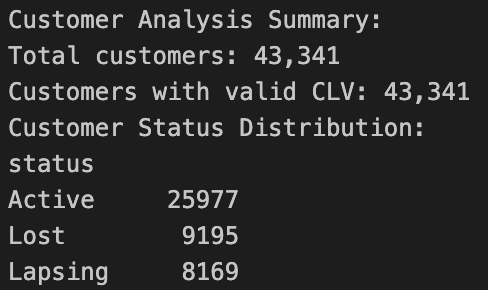
* With single transaction customers:
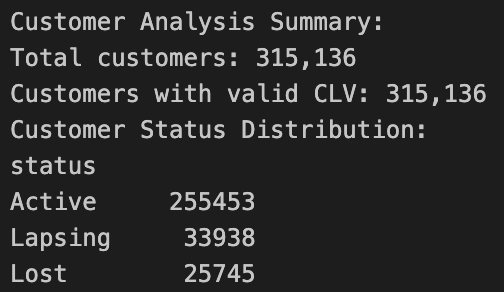

* We should absolutely exclude single transaction customers from modelling

### 28/8/25

* In theory If we chop the data at 2020, any customers from before then can be labeled as lapsed if they haven't interacted since
* To compare models we need all models to produce a p_alive at time t
  * At least a consistent set of outputs. Ie CLV, number of transactions in 5 years
* Scikit survival seems to have evaluation built in so just need to rebuild the other packages to fit in
* Can we derive a data driven cutoff time that varies by cohort or other characteristics (market)
  * Need to see if there is actually any variation in those groups



### 28/8/25

* Looking into 2nd transaction rates and time between. It is clear that part of the variation between cohorts and markets is due to scensoring, which is why survival based approaches are needed. 
* However we can look into specific windows like 6/12 month to compare more fairly and this paints a slightly different picture. But again even this is effected by the fact that total number of new customers in each cohort is changing
* I think therefore trying to calcuate lfetimes empirically is a bit dangerous and open to multiple biases
Next up is scikit-survival!
* MAybe it would make more sense to get prob of second transaction, which is inverse to prob of survival?
  * P(2nd purchase by t)=1−P(alive at t)
* You’re no longer answering:

“What’s the probability that a new customer makes a 2nd purchase within 16 months?”

Instead you’re answering:

“Given that a customer did eventually make a 2nd purchase, how is that 2nd purchase distributed over time?”
* Not usre if this is the right appracoh. DO we really have a survival scenario. There is no accurate churned metric we have. All our single tranasactors make this challenging
* PAreto insead of bg/nbd doesnt assume alive with one transcation, may be ideal


### 01/09/25

* We need to ensure that our definition of alive is relevant to the business
* Lots of customers do transact every 3 years, but is that really alive?
* Manual basis may be more benefitial

### 02/09/25

* Again we need to be very careful of the definitions of Alive, Lapsed etc as they are not real. Potentially what is more important is CLV associated with that customer given their p_alive

## Research


* Popular features for modelling
  * Age, gender, location, income
  * Tenure
  * Plan type (more buy or sell for us?)
  * Payment frequency
  * Login frequency, view frequency
  * Email engagement
  * Mode of payment
  * Billing issues
  * Market
  * Seasonality
  * Economic conditions
  * We could also include the types of camera they are buying selling and money spent
  * Cohorts as customeres grouped by month/quarter/year
* Modelling approaches pretty spot on, what we have should be enough
* Evaulation Metrics
  * Precision/Recall/F1
  * ROC/AUC
  * Ranking and Lift
  * Calibration (ensure probability reflects real world)
  * ROI
* Count your customers paper:
  * Pareto/NBD
    * While active, transaction in period t is poisson with mean yt
    * Heterogeneity of transaction rate y fol,lows gamma distribution
    * Each customer has lifetime T. Distributed exponentially with dropout u
    * Heterogeneity of dropout rate follows gamma dist
    * transaction rate and dropout rate vary independently acros customers
  * BQ/NBD
    * Purchase ratee follows poisson
    * Rates are distributed by gamma
    * AFter a purchase customer becomes inactive with prob p
    * p follows beta distribution
    * y and p are independent
* CLV talk
  * profit over entire future relationship
  * Which return, how foten, what spend
  * Break down the businiess model
  * 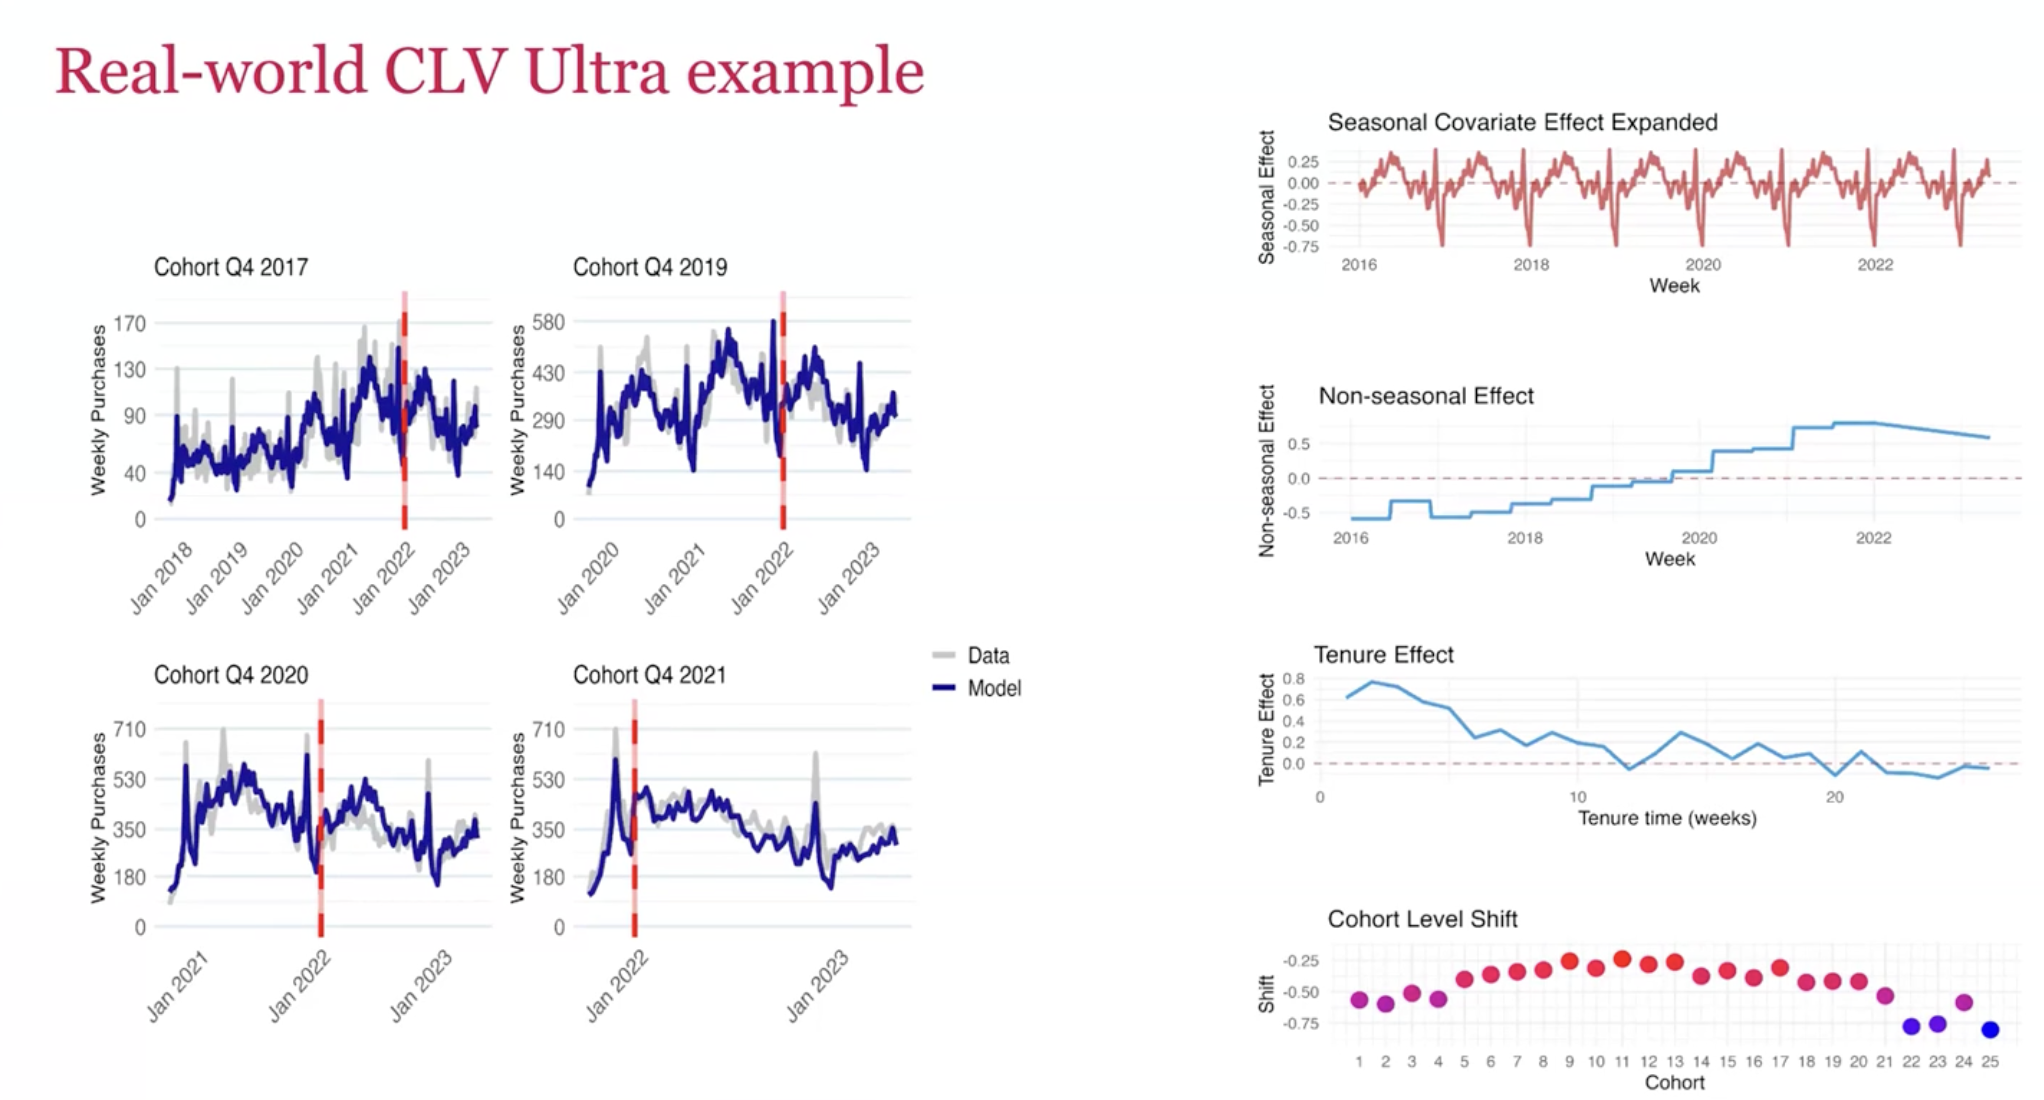
  * Appears to be looking at groups of customers rather than individual customers

## Key Findings

### EDA

Total Transaction deciles (all types):

| Decile | Count |
|-------|-------|
| 0.0   | 1.0   |
| 0.1   | 1.0   |
| 0.2   | 1.0   |
| 0.3   | 1.0   |
| 0.4   | 1.0   |
| 0.5   | 1.0   |
| 0.6   | 2.0   |
| 0.7   | 2.0   |
| 0.8   | 3.0   |
| 0.9   | 6.0   |
| 1.0   | 5904  |


As we can see most data (50%) are made of single transactions
The min is 1 and max is 5904! Next highest is 469

If we look at deciles for avg days between transactions excluding where there is only 1 transaction we get the following:

| Decile | Frequency (Days)      |
|-------|-------------|
| 0.0   | 0.000000    |
| 0.1   | 8.920307    |
| 0.2   | 31.143269   |
| 0.3   | 69.967610   |
| 0.4   | 115.762619  |
| 0.5   | 169.000000  |
| 0.6   | 235.769162  |
| 0.7   | 327.740022  |
| 0.8   | 462.586192  |
| 0.9   | 742.000653  |
| 1.0   | 5066.000000 |

These will almost certainly vary by category that customers fall into. But for now we are assuming all customers are the same


Looking at rate of 2nd transaction and time until 2nd transaction we see some interesting results:

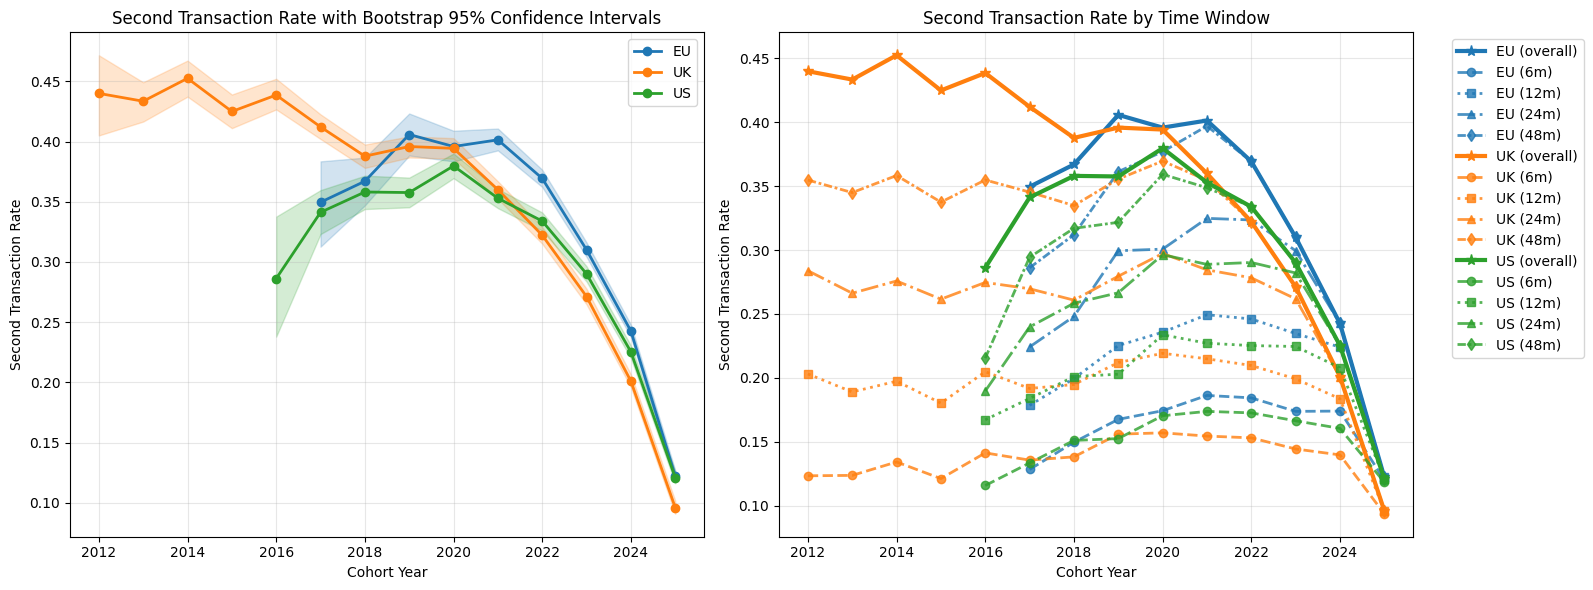
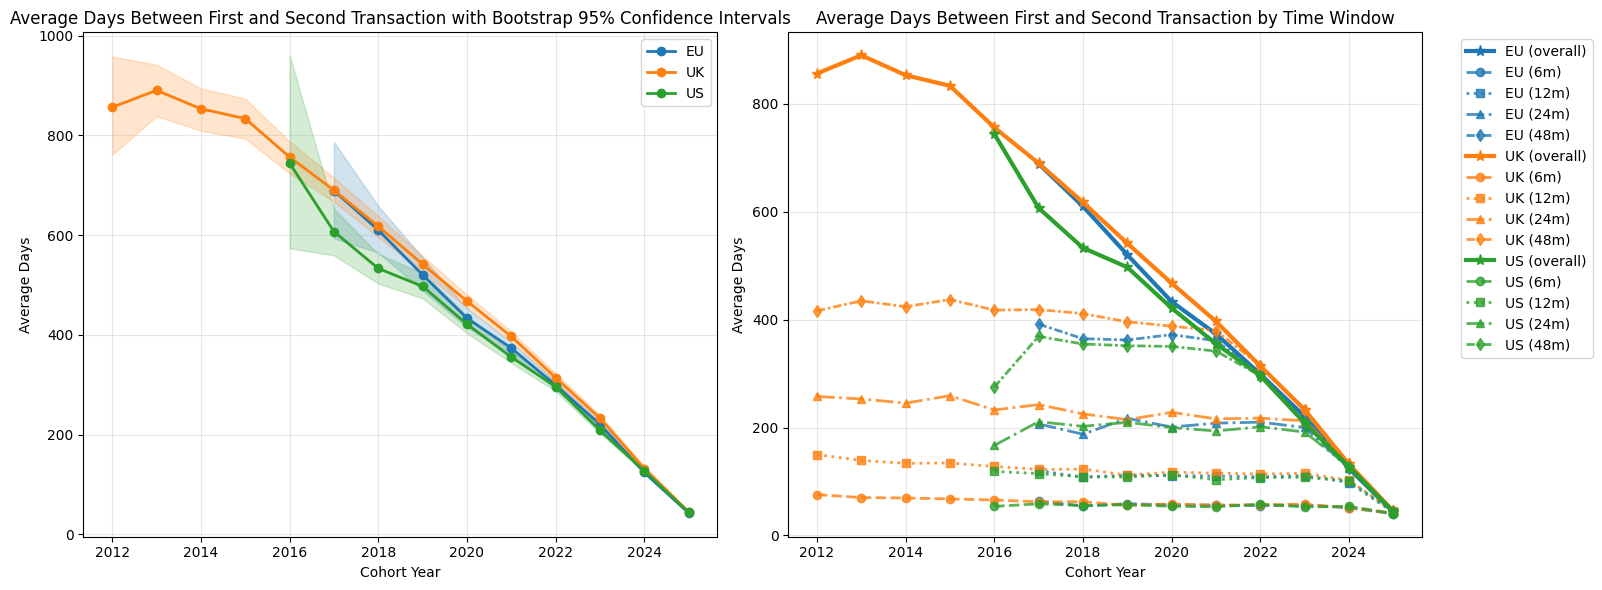

If we look directly at the average per cohort/market the ressults are skewed due to heavy sensoring. But if we look rates within an n month window we get a clearer picture of hoe things are changing
* Second transaction rate is actually increasing with cohort year into 2021 but now potentially decreasing
* Average days between transaction is decreasing with cohort year
* We'd probably also want to look at how that varies with total transactions too

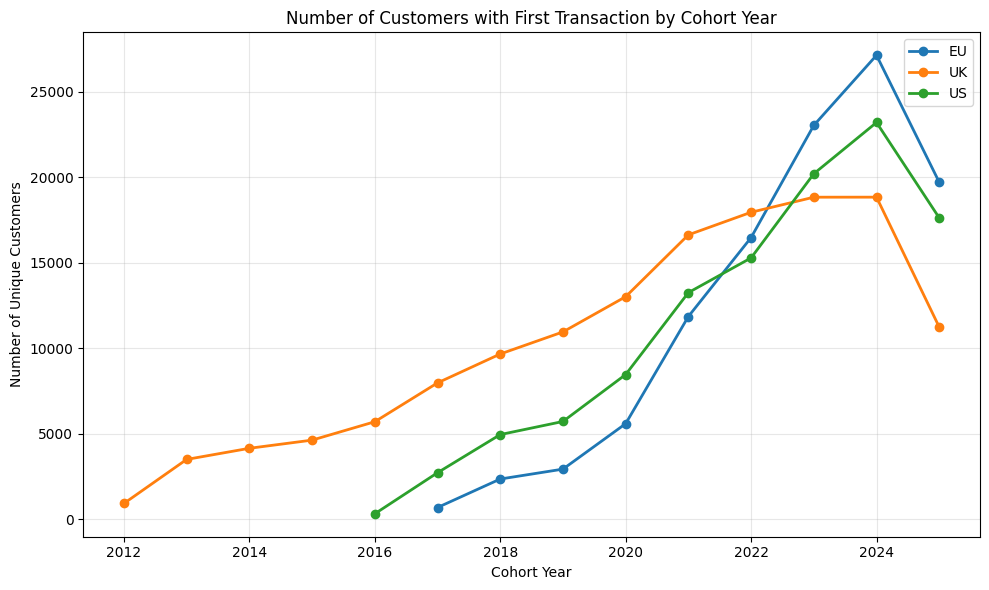

### Lifetimes

Modelling approach is very effective where there are **at least two transactions**. Evaluations perform well. It's fast to run. Simple. Explainable

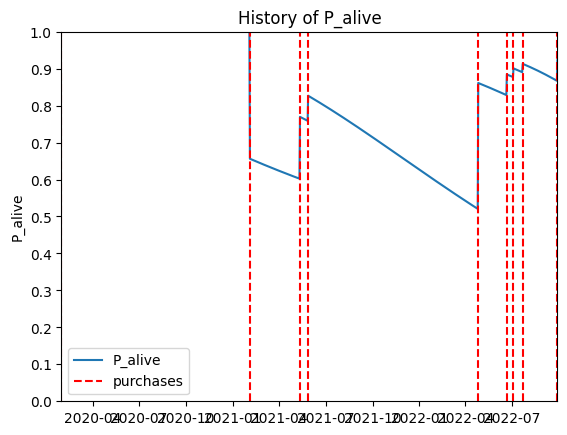

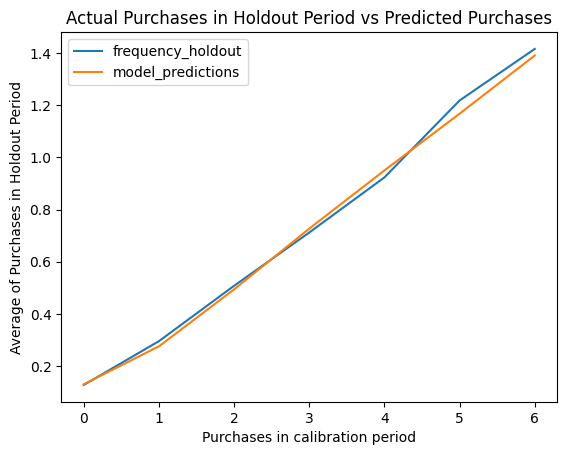

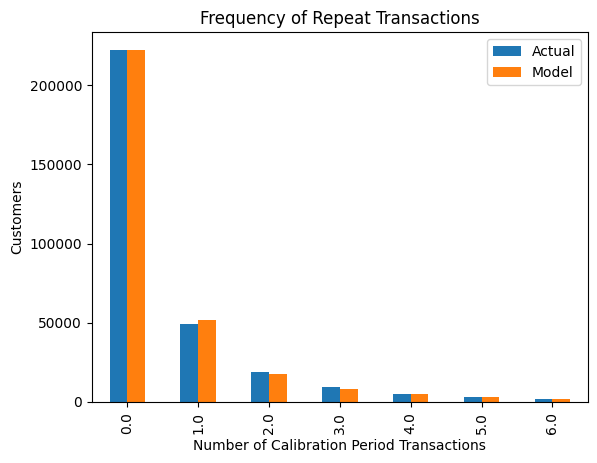

### Lifelines

* Model fits well but often assumes that all customers will follow the same survival curve
* There is the ability to split by groups if required
* I imagine this would give a good baseline but the performance of ML models predicting E = 1/0 would potentially be better

* 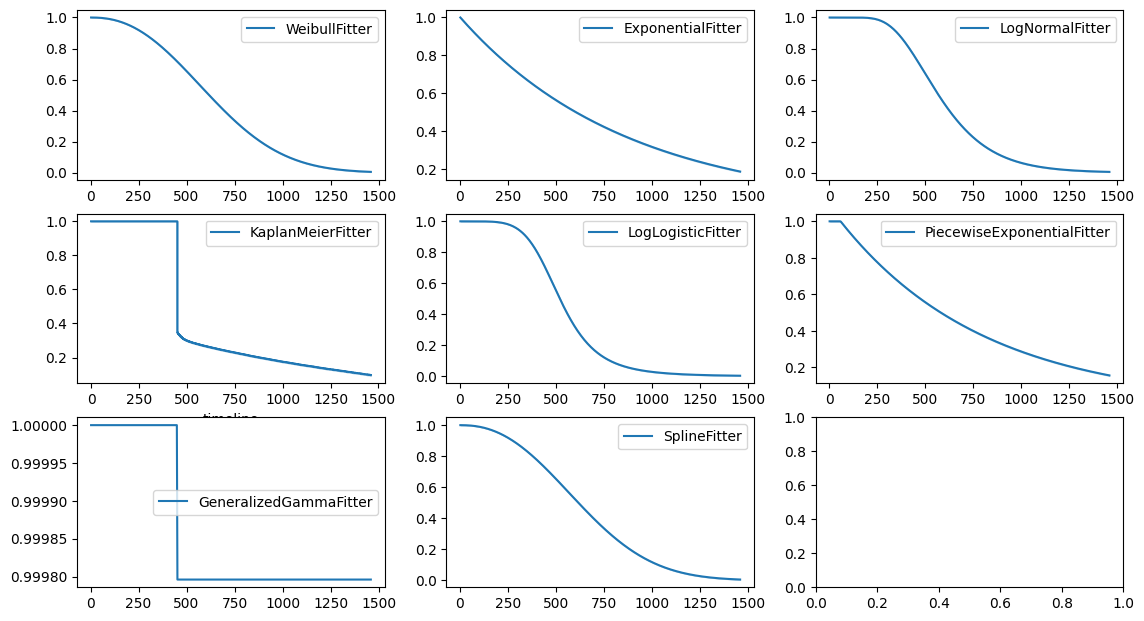

* 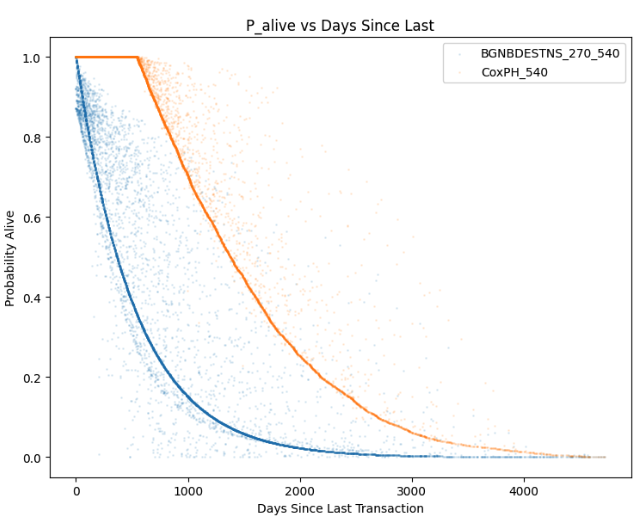

## References

* [Propensity to Lapse Kick off Slides](https://docs.google.com/presentation/d/179-C5yNzVS4nNXA_CbQMXH8GeMVuTY9nrZhiqoA1vOs/edit?slide=id.g370e1de7d7d_0_3#slide=id.g370e1de7d7d_0_3)
* [Options for approaches PtL Doc](https://docs.google.com/document/d/1ZJEun7c_fys9jN0EfnKOlXg8tthy1ArEfVPX_AJT86I/edit?tab=t.0)
* [Theta on CLV and ML Video](https://4634547.hs-sites.com/share/hubspotvideo/194067088397?utm_campaign=General&utm_medium=email&_hsenc=p2ANqtz-_eYBqy8-3U4YXMu1LaJqdalfo9lsuAElhOUYz4F9cDF1tcQDs6WmwKDzIzrVC8JBkcO_DOfHEBiqni60GK2fje8VYl2Q&_hsmi=374791551&utm_content=374791551&utm_source=hs_email)
* Dictionary from Theta project: 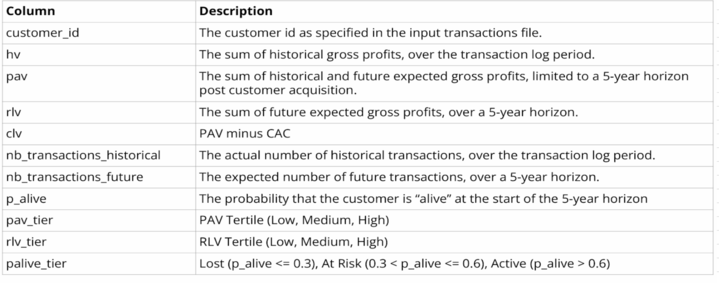
* [Counting Your Customers Paper](https://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf)
* Results to be uploaded to drive here: [Drive Link](https://drive.google.com/drive/folders/1b_KNrj49VFS92GiZI_mvyKizLHDP8JuE)